<a href="https://colab.research.google.com/github/xygxue/cluster/blob/master/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [2]:
my_drive_path = '/content/gdrive/MyDrive/'
dataset_path = my_drive_path + 'FSFM/master_thesis/data/'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score

from datetime import timedelta

In [4]:
raw_card = pd.read_csv(dataset_path+'clean/clean_card.csv', sep=',')
raw_loan = pd.read_csv(dataset_path+'clean/clean_loan.csv', sep=',')
raw_order = pd.read_csv(dataset_path+'clean/clean_order.csv', sep=',')
raw_trans = pd.read_csv(dataset_path+'clean/clean_trans.csv', sep=',')
raw_client = pd.read_csv(dataset_path+'clean/client_info.csv', sep=',')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


***Helper Functions***

In [5]:
def normalize(df):
  # use z-score to normalize the columns in dataframe 
  df_norm = (df - df.mean(axis=0))/df.std(axis=0)
  return df_norm

def encode_cyclicals(df):
    # "month","day","hour", "dayofweek"
    
    df['month_sin'] = np.sin(2*np.pi*df.month/12)
    df['month_cos'] = np.cos(2*np.pi*df.month/12)
    df.drop('month', axis=1, inplace=True)

    df['month_sin'] = np.sin(2*np.pi*df.month/12)
    df['month_cos'] = np.cos(2*np.pi*df.month/12)
    df.drop('month', axis=1, inplace=True)
    
    df['day_sin'] = np.sin(2*np.pi*df.day/31)
    df['day_cos'] = np.cos(2*np.pi*df.day/31)
    df.drop('day', axis=1, inplace=True)

    df['dayofweek_sin'] = np.sin(2*np.pi*df.dayofweek/7)
    df['dayofweek_cos'] = np.cos(2*np.pi*df.dayofweek/7)
    df.drop('dayofweek', axis=1, inplace=True)
    
    return df

def kmeans(X, cluster_number):
  kmeans = KMeans(n_clusters = cluster_number)
  kmeans.fit(X)
  labels = kmeans.labels_
  return labels

def cluster_score(X, labels):
  unique, counts = np.unique(labels, return_counts=True)
  cluster_count = dict(zip(unique, counts))

  silhouette = round(silhouette_score(X, labels),3)
  davies_bouldin = round(davies_bouldin_score(X, labels),3)

  return silhouette, davies_bouldin

def scatter_plot(X, labels, model_name):
  scatter = go.Scatter3d(x=X[:, 0], y=X[:, 1], z=X[:, 2], mode='markers', 
                       marker=dict(color=labels, line_width=0.1),
                       name=model_name)
  return scatter

### *Client table* 

In [ ]:
raw_client.head()

,account_id,frequency,disp_id,client_id,type,district_id,gender,age,district_name,region_name,...,city_number,urban_inhabitants_ratio,average salary,1995_unemployment_rate,1996_unemployment_rate,entrepreneurs_per_1000_inhabitants,crimes_committed_number_in_1995,crimes_committed_number_in_1996,lat,lon
0,A0000000576,Monthly Issuance,D0000000692,C0000000692,OWNER,74,0.0,62,Ostrava - mesto,north Moravia,...,1,100.0,10673,4.75,5.44,100,18782.0,18347,49.834650,18.282040
1,A0000000576,Monthly Issuance,D0000000693,C0000000693,DISPONENT,74,1.0,63,Ostrava - mesto,north Moravia,...,1,100.0,10673,4.75,5.44,100,18782.0,18347,49.834650,18.282040
2,A0000003818,Monthly Issuance,D0000004601,C0000004601,OWNER,1,1.0,63,Hl.m. Praha,Prague,...,1,100.0,12541,0.29,0.43,167,85677.0,99107,50.006143,14.336773
3,A0000003818,Monthly Issuance,D0000004602,C0000004602,DISPONENT,1,0.0,64,Hl.m. Praha,Prague,...,1,100.0,12541,0.29,0.43,167,85677.0,99107,50.006143,14.336773
4,A0000000704,Monthly Issuance,D0000000844,C0000000844,OWNER,22,1.0,53,Domazlice,west Bohemia,...,6,52.4,8620,1.10,1.25,100,1089.0,1117,49.500000,12.916670


In [ ]:
raw_client_copy = raw_client.copy()
client_no_disp = raw_client_copy[raw_client_copy['type'] == 'OWNER']
client_clean = client_no_disp.drop(columns=[
                      'disp_id_x','disp_id_y', 'client_id', 'account_id_y',  
                      'district_id', 'frequency', 'type', 'district_name',
                      'region_name', '1995_unemployment_rate', 
                      'crimes_committed_number_in_1995',
                      'number_of_municipalities_with_<499_inhabitants',
                      'number_of_municipalities_with_500-1499_inhabitants',
                      'number_of_municipalities_with_2000-9999_inhabitants',
                      'number_of_municipalities_with_>10000_inhabitants'])
client_clean.set_index('account_id_x', inplace=True)
client_clean.head()

,gender,age,inhabitants_number,city_number,urban_inhabitants_ratio,average salary,1996_unemployment_rate,entrepreneurs_per_1000_inhabitants,crimes_committed_number_in_1996,lat,lon
account_id_x,,,,,,,,,,,
A0000000576,0.0,62,323870,1,100.0,10673,5.44,100,18347,49.834650,18.282040
A0000003818,1.0,63,1204953,1,100.0,12541,0.43,167,99107,50.006143,14.336773
A0000000704,1.0,53,58400,6,52.4,8620,1.25,100,1117,49.500000,12.916670
A0000002378,0.0,23,93931,8,56.9,8427,1.54,107,1913,49.144040,15.003010
A0000002632,1.0,60,122603,8,80.0,8991,2.01,128,5273,50.232710,12.871170


In [ ]:
client_clean.isnull().sum()

gender                                0
age                                   0
inhabitants_number                    0
city_number                           0
urban_inhabitants_ratio               0
average salary                        0
1996_unemployment_rate                0
entrepreneurs_per_1000_inhabitants    0
crimes_committed_number_in_1996       0
lat                                   0
lon                                   0
dtype: int64

In [ ]:
client_norm = normalize(client_clean)
client_norm

,gender,age,inhabitants_number,city_number,urban_inhabitants_ratio,average salary,1996_unemployment_rate,entrepreneurs_per_1000_inhabitants,crimes_committed_number_in_1996,lat,lon
account_id_x,,,,,,,,,,,
A0000000576,-1.018731,1.046780,0.158534,-1.546618,1.552939,0.879002,0.910185,-0.916339,0.069923,0.039679,1.538008
A0000003818,0.981395,1.105308,2.628601,-1.546618,1.552939,2.289783,-1.439375,1.991495,2.665064,0.312926,-0.544652
A0000000704,0.981395,0.520028,-0.585696,0.160801,-0.848241,-0.671499,-1.054817,-0.916339,-0.483746,-0.493535,-1.294307
A0000002378,-1.018731,-1.235813,-0.486087,0.843769,-0.621239,-0.817260,-0.918814,-0.612535,-0.458167,-1.060703,-0.192953
A0000002632,0.981395,0.929724,-0.405706,0.843769,0.544040,-0.391306,-0.698396,0.298875,-0.350197,0.673926,-1.318326
...,...,...,...,...,...,...,...,...,...,...,...
A0000000124,0.981395,0.344444,-0.309158,1.185253,-1.781473,-0.578605,-0.501427,-0.438933,-0.394510,-1.024645,0.597290
A0000003958,0.981395,0.168860,-0.444203,0.160801,-0.358925,-0.804421,-0.013694,-0.655936,-0.445571,-0.815630,1.068758
A0000000777,0.981395,1.105308,-0.483617,1.526736,0.634841,0.106395,0.080101,-0.916339,-0.429536,0.592012,-1.440305


### *Transaction Table*

In [10]:
raw_trans.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,T0000695247,A0000002378,1993-01-01,credit,deposit,700.0,700.0,NaN,NaN,NaN
1,T0000171812,A0000000576,1993-01-01,credit,deposit,900.0,900.0,NaN,NaN,NaN
2,T0000207264,A0000000704,1993-01-01,credit,deposit,1000.0,1000.0,NaN,NaN,NaN
3,T0001117247,A0000003818,1993-01-01,credit,deposit,600.0,600.0,NaN,NaN,NaN
4,T0000579373,A0000001972,1993-01-02,credit,deposit,400.0,400.0,NaN,NaN,NaN


**Recency, Frequency, Monetary**

In [11]:
date_col = pd.DatetimeIndex(raw_trans['date'])
raw_trans['date'] = date_col
benchmark_date = date_col.max() + timedelta(days=1)
print(benchmark_date)

1999-01-01 00:00:00


In [12]:
df_rfm = raw_trans.groupby(['account_id']).agg({
        'date': lambda x: (benchmark_date - x.max()).days,
        'trans_id': 'count',
        'amount': 'sum'})
df_rfm.rename(columns={'date': 'Recency','trans_id': 'Frequency',
                       'amount': 'Monetary'}, inplace=True)

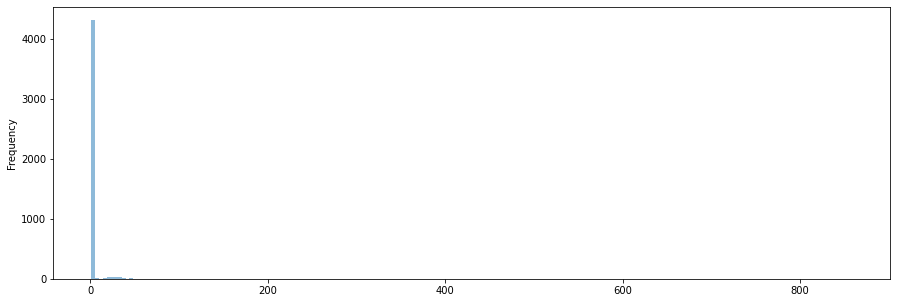

In [13]:
df_rfm['Recency'].plot.hist(figsize=(15, 5), alpha=0.5, bins=200)

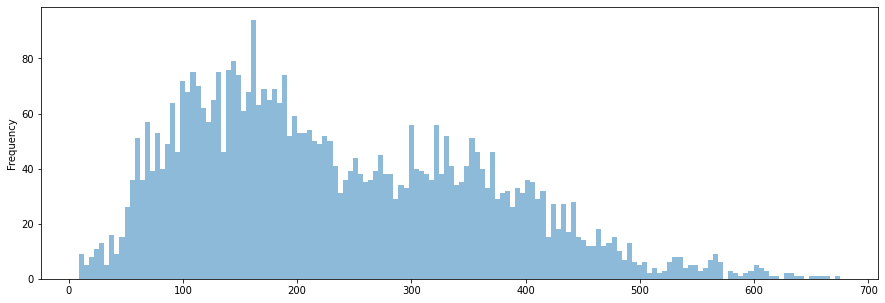

In [14]:
df_rfm['Frequency'].plot.hist(figsize=(15, 5), alpha=0.5, bins=150)

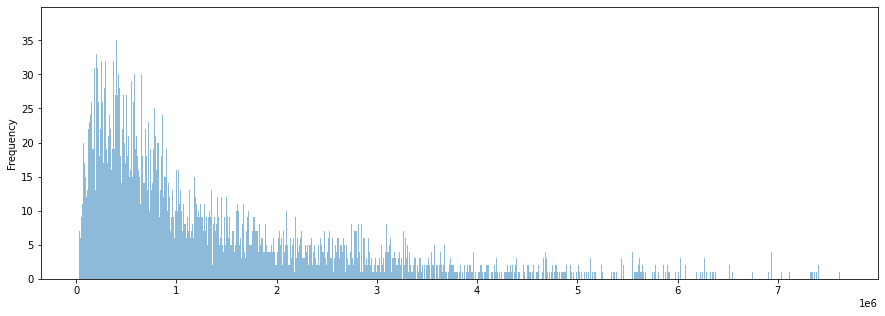

In [15]:
df_rfm['Monetary'].plot.hist(figsize=(15, 5), alpha=0.5, bins=1000)

In [16]:
df_rfm_norm = normalize(df_rfm)
df_rfm_norm.head()

,Recency,Frequency,Monetary
account_id,,,
A0000000001,-0.084869,0.033601,-0.764274
A0000000002,-0.084869,1.917724,1.325307
A0000000003,-0.084869,-0.928169,-0.824600
A0000000004,-0.084869,-0.384218,-0.782490
A0000000005,-0.084869,-1.188320,-0.921045


In [17]:
raw_trans.operation.unique()

array(['deposit', 'collection_from_another_bank', 'withdraw_cash',
       'interest_pmt', 'transer_to_another_bank',
       'credit_card_withdrawal'], dtype=object)

In [18]:
raw_trans.k_symbol.unique()

array([nan, 'pension', 'interest_pmt', 'household', 'service',
       'insurrance_pmt', 'interest_for_negetive_balance', 'loan_pmt'],
      dtype=object)

One Hot Encoding Categorical Features

In [19]:
one_hot_trans = pd.get_dummies(raw_trans[['operation']])

Cyclicals Encoding

In [20]:
raw_trans['year'] = date_col.year
raw_trans['month'] = date_col.month
raw_trans['day'] = date_col.day
raw_trans['dayofweek'] = date_col.dayofweek

In [21]:
trans_to_merge = raw_trans[['trans_id', 'account_id', 'amount', 'balance', 
                            'year', 'month', 'day', 'dayofweek']]
trans = trans_to_merge.join(one_hot_trans)
trans.set_index('trans_id', inplace=True)
trans_norm = normalize(trans.drop(columns=['account_id'], inplace=False))
trans_norm['account_id'] = trans['account_id']
trans_norm

,amount,balance,year,month,day,dayofweek,operation_collection_from_another_bank,operation_credit_card_withdrawal,operation_deposit,operation_interest_pmt,operation_transer_to_another_bank,operation_withdraw_cash,account_id
trans_id,,,,,,,,,,,,,
T0000695247,-0.548597,-1.709854,-2.504467,-1.555385,-1.701858,0.494807,-0.256539,-0.087555,2.395658,-0.457933,-0.495586,-0.836599,A0000002378
T0000171812,-0.527595,-1.700812,-2.504467,-1.555385,-1.701858,0.494807,-0.256539,-0.087555,2.395658,-0.457933,-0.495586,-0.836599,A0000000576
T0000207264,-0.517094,-1.696291,-2.504467,-1.555385,-1.701858,0.494807,-0.256539,-0.087555,2.395658,-0.457933,-0.495586,-0.836599,A0000000704
T0001117247,-0.559098,-1.714375,-2.504467,-1.555385,-1.701858,0.494807,-0.256539,-0.087555,2.395658,-0.457933,-0.495586,-0.836599,A0000003818
T0000579373,-0.580101,-1.723418,-2.504467,-1.555385,-1.603791,0.993325,-0.256539,-0.087555,2.395658,-0.457933,-0.495586,-0.836599,A0000001972
...,...,...,...,...,...,...,...,...,...,...,...,...,...
T0003626622,-0.615563,-1.120765,1.073430,1.514539,1.240166,-0.003711,-0.256539,-0.087555,-0.417421,2.183722,-0.495586,-0.836599,A0000002906
T0003627616,-0.613568,-0.857833,1.073430,1.514539,1.240166,-0.003711,-0.256539,-0.087555,-0.417421,2.183722,-0.495586,-0.836599,A0000002935
T0003625403,-0.615784,-1.079676,1.073430,1.514539,1.240166,-0.003711,-0.256539,-0.087555,-0.417421,2.183722,-0.495586,-0.836599,A0000002869


In [22]:
trans_acc_grp_unnorm = trans.groupby(['account_id'])
trans_acc_grp_unnorm.size()

account_id
A0000000001    239
A0000000002    478
A0000000003    117
A0000000004    186
A0000000005     84
              ... 
A0000011333    368
A0000011349    304
A0000011359    378
A0000011362    344
A0000011382    253
Length: 4500, dtype: int64

In [23]:
trans_acc_grp = trans_norm.groupby(['account_id'])
max_trans_len = trans_acc_grp.size().max()
max_trans_len

675

In [24]:
sequence_input_list = []
sequence_output_list = []
non_sos_eos_list = []
no_padding_list = []
for k, v in trans_acc_grp:
  user_trans_array = v.drop(columns=['account_id']).values
  array = user_trans_array.copy()
  array_no_sos_eos = user_trans_array.copy()
  # add start and end to sequence of transations
  add_start_to_array = np.insert(array, 0, [-1]*12, axis=0)
  input_array = np.append(add_start_to_array, [[-2]*12], axis=0)
  output_array = np.append(array, [[-2]*12], axis=0)
  # resize array to max_lenght
  input_array.resize((max_trans_len, 12), refcheck=False)
  output_array.resize((max_trans_len, 12), refcheck=False)
  array_no_sos_eos.resize((max_trans_len, 12), refcheck=False)
  # append them to list
  sequence_input_list.append(input_array)
  sequence_output_list.append(output_array)
  non_sos_eos_list.append(array_no_sos_eos)
  no_padding_list.append(array)

In [25]:
sequence_input_array = np.array(sequence_input_list)
sequence_output_input_array = sequence_input_array
sequence_output_array = np.array(sequence_output_list)
non_sos_eos_list_array = np.array(non_sos_eos_list)
no_padding_list_array = np.array(no_padding_list)
sequence_output_array.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


(4500, 675, 12)

## **Modeling**

### **LSTM Extract Latent Space**

In [32]:
import tensorflow as tf
from keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers.core import Activation, Dropout, Dense
from keras.layers.advanced_activations import PReLU, LeakyReLU

from tensorflow import feature_column, keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE
from keras.layers import Dense, LSTM, GRU, dot, Input, Embedding, \
 TimeDistributed, Dropout, Bidirectional, Concatenate, GlobalMaxPooling1D

In [33]:
def create_model():
  latent_dim = 16
  decoder_dim = 12
  num_dynamic_features = 12
  ###########################################  encoder  ###########################################

  # Sequence input shape is N*2 which N is sequence length and 2 is price and time
  sequence_input = Input(name='sequence_input', shape=(None, num_dynamic_features))

  # Many_to_one_lstm
  outputs  = LSTM(128, return_sequences=True)(sequence_input)
  # outputs = GRU(2048, return_sequences=True)(outputs)
  # outputs = Dropout(0.2, input_shape=(2,))(outputs)
  encoder_out , hidden_state, cell_state = LSTM(latent_dim, return_state=True, return_sequences=True)(outputs)

  latent_space = Concatenate()([hidden_state, cell_state])
  #Layer below output can be used for clustering purposes
  latent_space = Dense(latent_dim, activation = 'relu', name='latent_space')(latent_space)

  ###########################################  /encoder  ###########################################

  ###########################################  decoder  ###########################################

  # Temporary input with a time step delay for producing sequence output
  # This input is exacly similar to sequence_input with only this diffrence that has a time step delay
  sequence_output_input = Input(name='sequence_output_input', shape=(None, num_dynamic_features))

  # One to many GRU (because of its simplicity, we used GRU instead of LSTM)
  decoder_out = GRU(latent_dim, return_sequences=True)(sequence_output_input, initial_state = latent_space)
  ###########################################  attention  ###########################################
  attention = dot([decoder_out, encoder_out], axes=[2, 2])
  attention = Activation('softmax')(attention)
  context = dot([attention, encoder_out], axes=[2,1])
  decoder_combined_context = Concatenate()([context, decoder_out])
  ###########################################  /attention  ###########################################

  decoder_outputs = TimeDistributed(Dense(decoder_dim, activation='sigmoid'),name='decoder_outputs')(decoder_combined_context)

  ###########################################  /decoder  ###########################################

  # Model has three inputs and 2 outputs (last input is temorary)
  model = Model(inputs = [sequence_input, sequence_output_input],
              outputs = [decoder_outputs])

  return model

In [34]:
lr = 0.01
adam = Adam(lr)
with tf.device("/gpu:0"):
    model = create_model()
    model.compile(optimizer=adam, loss=MSE)
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence_input (InputLayer)    [(None, None, 12)]   0           []                               
                                                                                                  
 lstm (LSTM)                    (None, None, 128)    72192       ['sequence_input[0][0]']         
                                                                                                  
 lstm_1 (LSTM)                  [(None, None, 16),   9280        ['lstm[0][0]']                   
                                 (None, 16),                                                      
                                 (None, 16)]                                                      
                                                                                              

In [ ]:
batch_size = 128
inputs = [sequence_input_array, sequence_output_input_array]
outputs = [sequence_output_array]

training_history = model.fit(inputs, outputs,
                             epochs=100,
                             batch_size = batch_size,
                             validation_split=0.1)

Epoch 1/100
32/32 [==============================] - 13s 150ms/step - loss: 0.3767 - val_loss: 0.4163
Epoch 2/100
 6/32 [====>.........................] - ETA: 2s - loss: 0.3170

In [ ]:
encoder = Model(model.input, model.get_layer("latent_space").output)
predictions = encoder.predict(inputs, batch_size=batch_size, verbose=1)

### **Dynamic Time Warping (DTW)**

In [6]:
!pip install dtaidistance

     |████████████████████████████████| 797 kB 28.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for dtaidistance: filename=dtaidistance-2.3.6-cp37-cp37m-linux_x86_64.whl size=1593634 sha256=9c8adf2747b4665e9eaf8a3d149315fd698b63e0410158f439eb0879653ad370
  Stored in directory: /root/.cache/pip/wheels/a4/04/e5/ff7fd821276e7ec68893652d36b6a13f230ecdcafdc3283b3f
Successfully built dtaidistance


In [7]:
from dtaidistance import dtw_ndim

In [31]:
%%time
distance_1d = []
distance_2d = []
for i in non_sos_eos_list_array:
  for j in non_sos_eos_list_array:
    d = dtw_ndim.distance(i, j)
    distance_1d.append(d)
  print(distance_1d)
  distance_2d.append(distance_1d)
  print(distance_2d)

KeyboardInterrupt: ignored

In [ ]:
from numpy import save

save('dtw_matrix.npy', np.array(distance_2d))

### **Evaluation**

In [ ]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

[0.878, 0.678, 0.651, 0.517, 0.502, 0.495, 0.488, 0.485, 0.462, 0.446, 0.443, 0.442, 0.439, 0.42, 0.413, 0.411, 0.403, 0.394]
Silhouette: The best value --> 1 and the worst value --> -1.
Davies–Bouldin index: lower values --> better clustering.
[0.878, 0.679, 0.651, 0.517, 0.497, 0.495, 0.488, 0.484, 0.459, 0.446, 0.438, 0.437, 0.436, 0.42, 0.413, 0.406, 0.421, 0.396]
Silhouette: The best value --> 1 and the worst value --> -1.
Davies–Bouldin index: lower values --> better clustering.
[0.878, 0.679, 0.652, 0.517, 0.496, 0.494, 0.488, 0.485, 0.462, 0.447, 0.442, 0.444, 0.438, 0.419, 0.417, 0.419, 0.42, 0.405]
Silhouette: The best value --> 1 and the worst value --> -1.
Davies–Bouldin index: lower values --> better clustering.


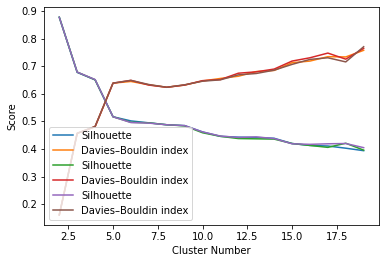

In [ ]:
for pca_num in range (2, 6):
  sc = StandardScaler()
  encode_pred_norm = sc.fit_transform(predictions)
  pca = PCA(n_components=n_components)
  encoder_pred = pca.fit_transform(encode_pred_norm)
  sil_list = []
  db_index_list = []
  for cluster_num in range(2, 10):
    labels = kmeans(encoder_pred, cluster_num)
    sil, db = cluster_score(encoder_pred, labels)
    sil_list.append(sil)
    db_index_list.append(db)
  print(sil_list)
  print("Silhouette: The best value --> 1 and the worst value --> -1.")
  print("Davies–Bouldin index: lower values --> better clustering.")
  x_axis = list(range(2, 20))
  plt.plot(x_axis, sil_list, label='Silhouette')
  plt.plot(x_axis, db_index_list, label='Davies–Bouldin index')
  plt.xlabel("Cluster Number")
  plt.ylabel("Score")
  plt.legend()

In [ ]:
encoder_label = kmeans(encoder_pred, 2)

fig = go.Figure(data=[scatter_plot(encoder_pred, encoder_label, "LSTM Encoder")])
fig.show()

A Transformer-Based Framework For Multivariate Time Series Representation Learning